In [18]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import os

folder = "/content/drive/MyDrive/Colab Notebooks/photo"   # 정확한 경로
filenames = os.listdir(folder)

data = []

for fname in filenames:
    path = os.path.join(folder, fname)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("❌ 읽기 실패:", fname)
        continue  # 이 파일은 건너뛰기

    data.append(img)

print("정상적으로 로드된 이미지 개수:", len(data))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
❌ 읽기 실패: Thumbs.db
정상적으로 로드된 이미지 개수: 296


In [19]:
import numpy as np

data_flat = np.array([img.flatten() for img in data])
print(data_flat.shape)


(296, 10000)


In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_flat)


PCA(n_components=2)

In [45]:
data_pca = pca.transform(data_flat)
print(data_pca.shape)

(296, 2)


In [35]:
import matplotlib.pyplot as plt
def draw(arr, ratio=1):
  n = len(arr)
  rows = int(np.ceil(n/10))
  cols = n if rows<2 else 10
  fig, axs = plt.subplots(rows, cols, figsize=(cols*ratio, rows*ratio), squeeze=False)

  for i in range(rows):
    for j in range(cols):
      if i*10 + j < n:
        axs[i,j].imshow(arr[i*10 + j] , cmap='gray_r')
      axs[i,j].axis('off')
  plt.show()

In [46]:
from sklearn.cluster import KMeans

# 1) KMeans 학습
km = KMeans(n_clusters=3, random_state=42)
km.fit(data_pca)

# 2) 각 클러스터별 이미지 시각화
for label in range(3):
    cluster_flat = data_pca[km.labels_ == label]        # FLAT 이미지
    cluster_imgs = cluster_flat.reshape(-1, 100, 100)    # 100x100 이미지로 복원

    print(f"클러스터 {label} 개수:", cluster_imgs.shape[0])
    draw(cluster_imgs[:50])   # 50개까지만 보기
    print("\n")


ValueError: cannot reshape array of size 190 into shape (100,100)

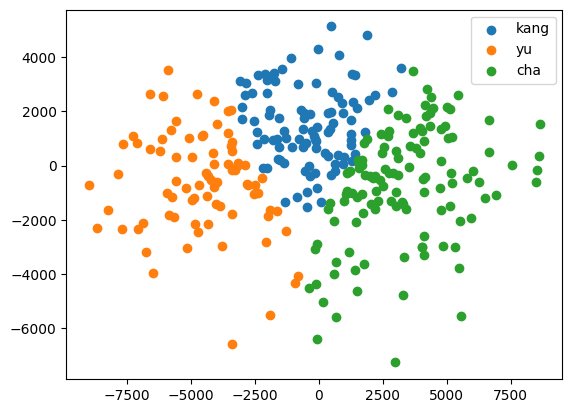

In [47]:
for label in range(3):
    cluster = data_pca[km.labels_ == label]
    plt.scatter(cluster[:,0], cluster[:,1])

plt.legend(['kang', 'yu', 'cha'])
plt.show()


(296, 10000)


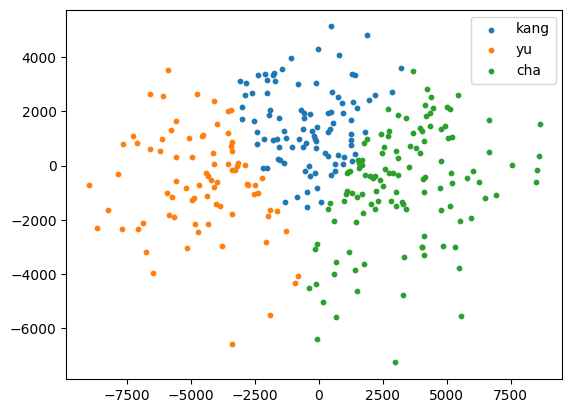

In [48]:
# 1) 평탄화된 이미지: (샘플수, 픽셀수)
print(data_flat.shape)   # (296, 10000) 같은 형태

# 2) PCA로 2차원 축소
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_flat)   # (296, 2)

# 3) KMeans 클러스터링 (2차원 공간에서)
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(data_2d)

# 4) 2D 상에 군집 시각화
import matplotlib.pyplot as plt

for label in range(3):
    cluster = data_2d[labels == label]
    plt.scatter(cluster[:, 0], cluster[:, 1], s=10)

plt.legend(['kang', 'yu', 'cha'])
plt.show()


In [50]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1) 정답 라벨
true_labels = np.array([0]*100 + [1]*100 + [2]*96)

# 2) PCA 2차원 축소
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_flat)

# 3) KMeans
km = KMeans(n_clusters=3, random_state=42)
labels = km.fit_predict(data_2d)

# 4) 군집 → 실제 라벨 매핑
mapping = {}
for cluster_id in range(3):
    idx = np.where(labels == cluster_id)[0]
    counts = np.bincount(true_labels[idx], minlength=3)
    mapping[cluster_id] = np.argmax(counts)

print("클러스터 → 실제 라벨 매핑:", mapping)

# 5) 매핑 적용
pred_labels = np.array([mapping[c] for c in labels])

# 6) 정확도 계산
accuracy = np.mean(pred_labels == true_labels)
print("정답률:", accuracy)


클러스터 → 실제 라벨 매핑: {0: np.int64(0), 1: np.int64(0), 2: np.int64(1)}
정답률: 0.3547297297297297
